# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [38]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, scale
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/bikes_rent.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [7]:
df = pd.read_csv(path)
df.head()


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

**Постройте** графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

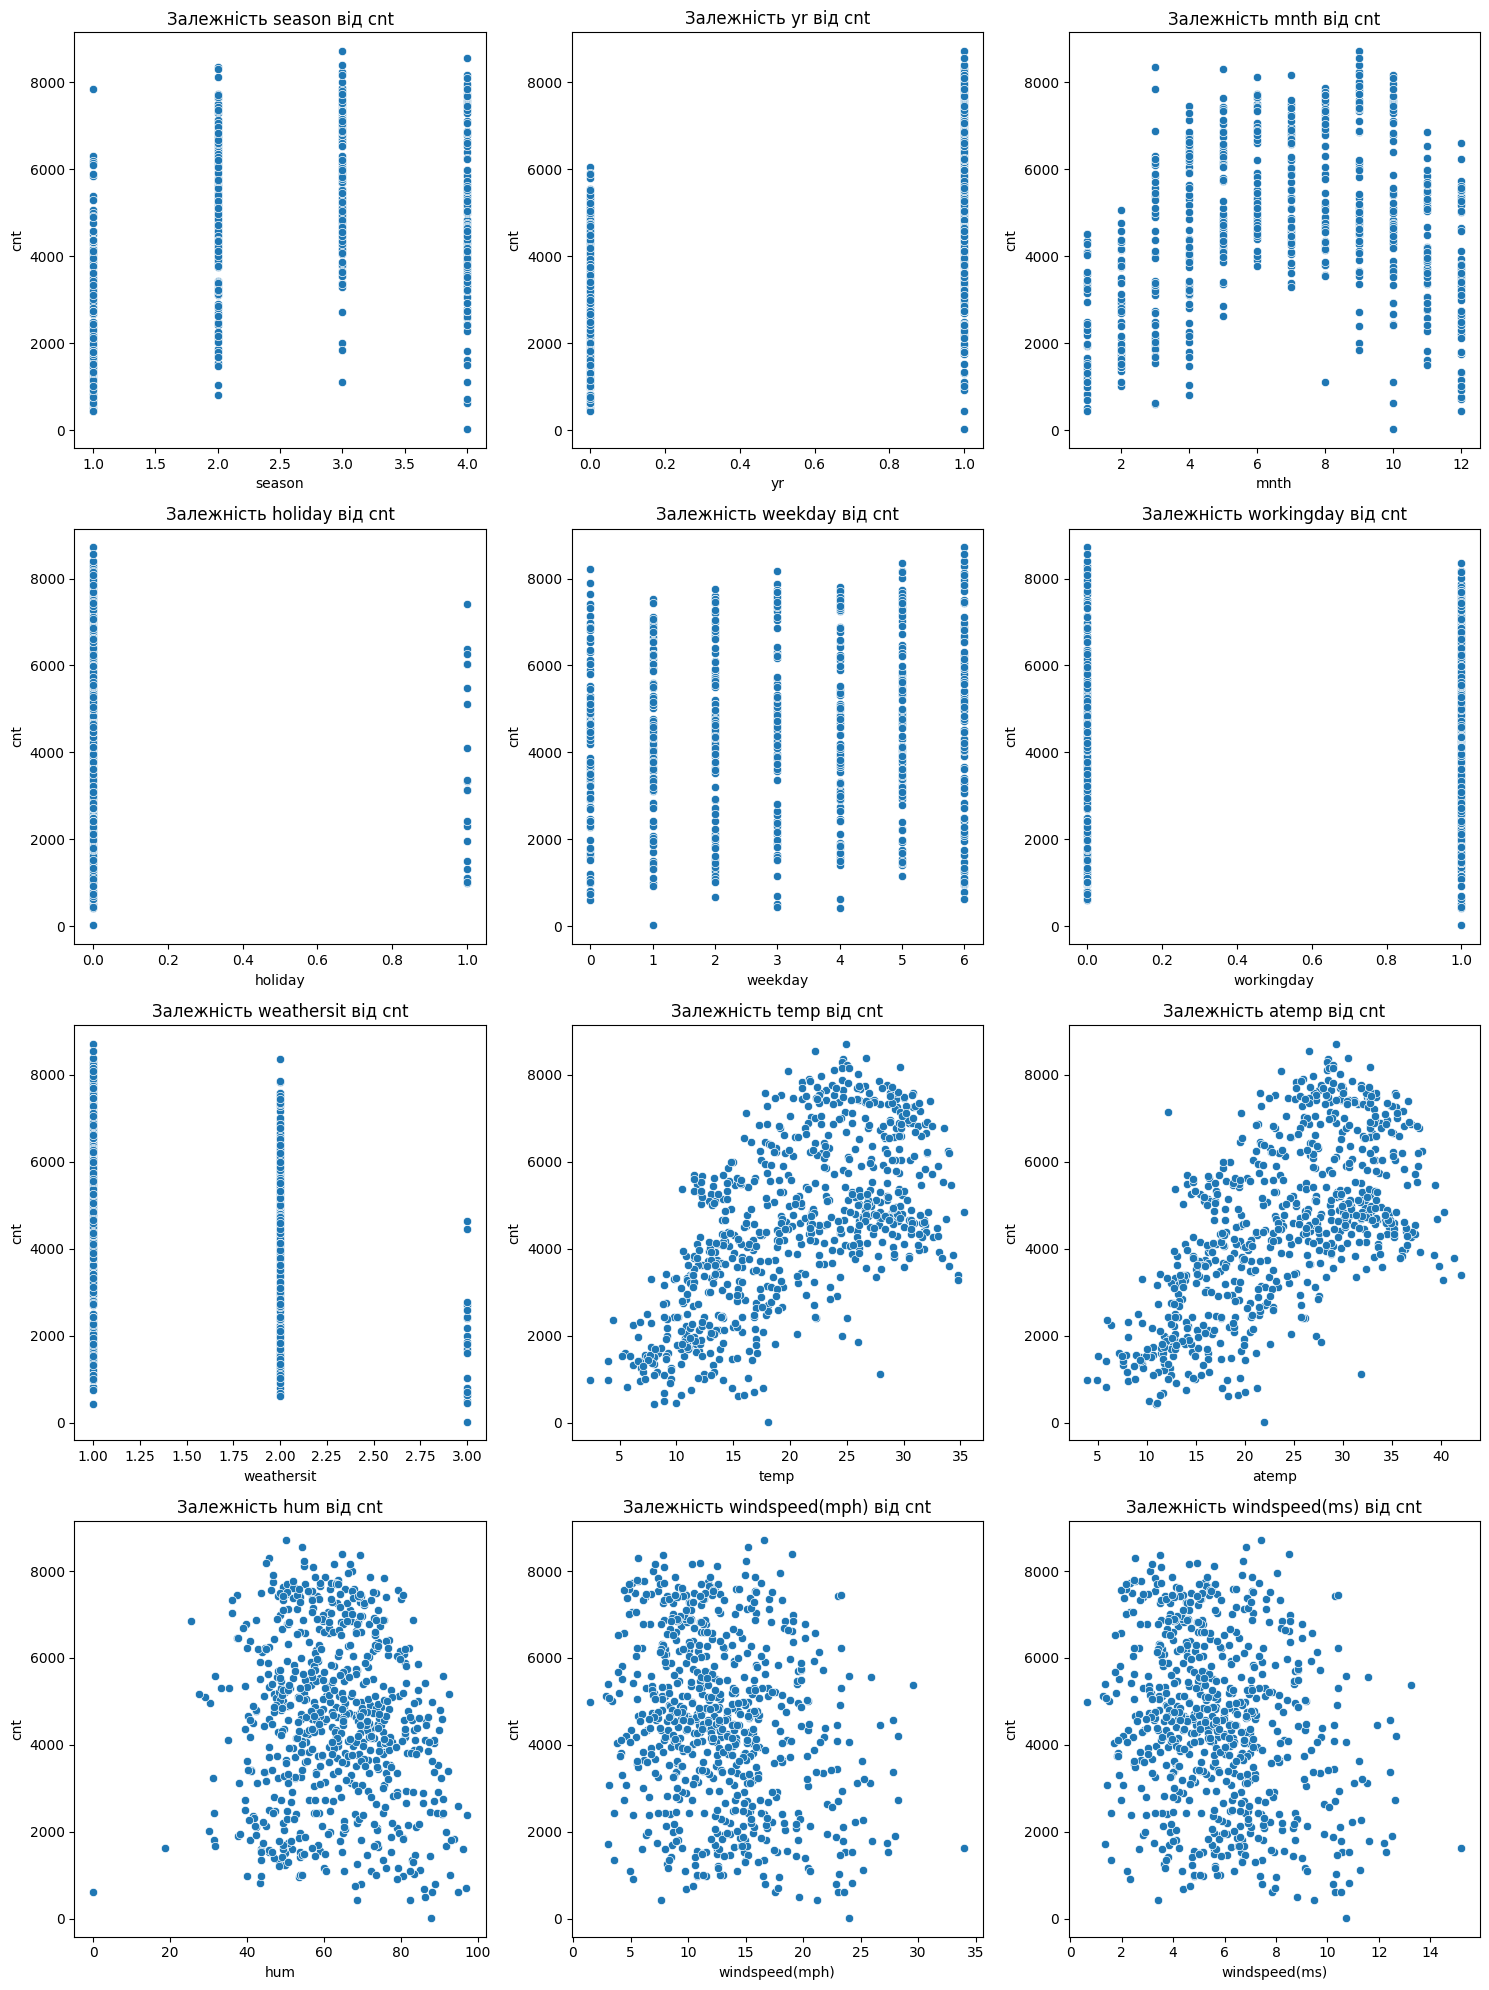

      count         mean          std     min      25%     50%      75%  \
mnth                                                                      
1      62.0  2176.338710  1161.674370   431.0  1251.75  1939.0  3235.75   
2      57.0  2655.298246  1145.313307  1005.0  1623.00  2402.0  3777.00   
3      62.0  3692.258065  1899.301812   605.0  2077.00  3216.5  5361.00   
4      60.0  4484.900000  1776.160778   795.0  3188.25  4293.5  6205.25   
5      62.0  5349.774194  1298.711561  2633.0  4409.00  4890.5  6405.50   
6      60.0  5772.366667  1240.400031  3767.0  4834.50  5308.5  6983.00   
7      62.0  5563.677419  1273.751871  3285.0  4491.50  5446.5  6678.75   
8      62.0  5664.419355  1494.516146  1115.0  4582.50  5229.5  7121.00   
9      60.0  5766.516667  1810.130649  1842.0  4532.00  5384.0  7509.25   
10     62.0  5199.225806  1988.392517    22.0  3967.25  5013.0  7238.75   
11     60.0  4247.183333  1285.712709  1495.0  3386.00  4081.0  5317.00   
12     62.0  3403.806452 

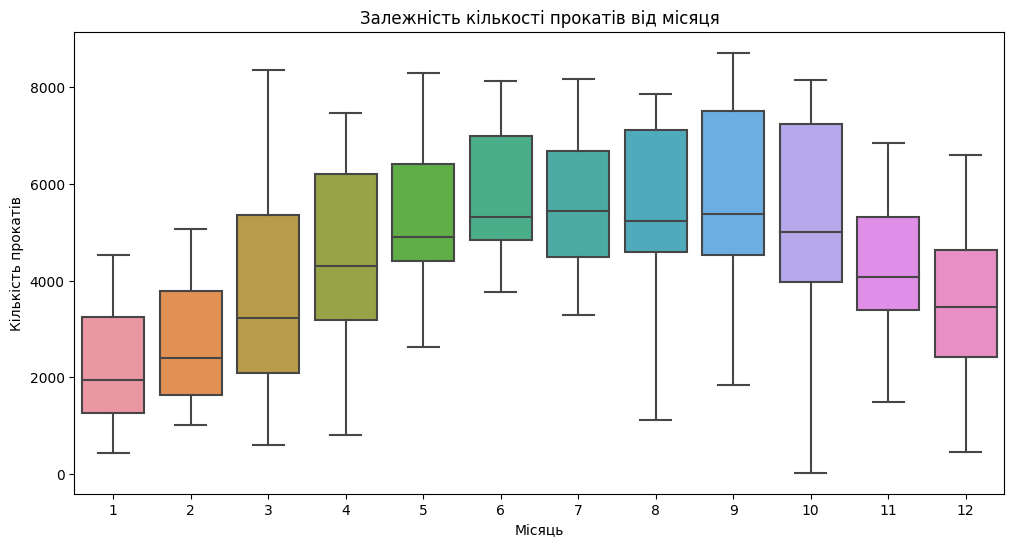

cnt               1.000000
atemp             0.631066
temp              0.627494
yr                0.566710
season            0.406100
mnth              0.279977
weekday           0.067443
workingday        0.061156
holiday          -0.068348
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
weathersit       -0.297391
Name: cnt, dtype: float64


In [16]:
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

plt.figure(figsize=(15, 20))

for i, attribute in enumerate(attributes, 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=attribute, y='cnt', data=df)
    plt.title(f'Залежність {attribute} від cnt')

# Показ графіків
plt.tight_layout()
plt.show()

# Розрахувати статистику для кількості прокатів за кожний місяць
monthly_stats = df.groupby('mnth')['cnt'].describe()

# Вивести статистику
print(monthly_stats)


# Побудова графіка
plt.figure(figsize=(12, 6))
sns.boxplot(x='mnth', y='cnt', data=df)
plt.title('Залежність кількості прокатів від місяця')
plt.xlabel('Місяць')
plt.ylabel('Кількість прокатів')
plt.show()


correlation_with_cnt = df.corr()['cnt'].sort_values(ascending=False)
print(correlation_with_cnt)


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно.
**Відповідь**:
1. Найбільша орендна спроможність у липні та вересні. Найменша у січні. Сезонні патерни:

1) Сезон найбільшої оренди: кінець весни - середина осені.

2) Сезон середньої оренди: середина весни та пізня осінь - початок зими

3) Найменша оренда: зима - початок весни

2.Температура в Цельсіях та як ця температура відчувається.

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [19]:
# Виберіть всі ознаки, крім останнього ('cnt')
features = df.iloc[:, :-1]

# Вирахуйте кореляцію за допомогою методу corrwith
correlations = features.corrwith(df['cnt'])

# Виведіть кореляції
print(correlations)
# Виберіть вещественні признаки
numeric_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']]

# Розрахуйте кореляційну матрицю
numeric_correlations = numeric_features.corr()

# Виведіть кореляції
print(numeric_correlations)


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

**Висновок**:
Ознаки температури та відчуття температури схожі між собою, а також швидкість вітру в різних одиницях взагалі ідентичні величини

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [32]:
# Виберіть вказані признаки та цільову змінну
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]

# Обчисліть попарні кореляції
pairwise_correlations = selected_features.corr()

# Виведіть кореляції
print(pairwise_correlations)

# Виберіть тільки вещественні признаки для визначення мультиколінеарності
numeric_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']]

# Масштабуємо дані для застосування лінійної регресії
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Застосовуємо лінійну регресію для отримання коефіцієнтів
model = LinearRegression()
model.fit(numeric_features_scaled, df['cnt'])

# Отримуємо коефіцієнти і визначаємо VIF для кожного признака
coefficients = model.coef_
vif = 1 / (1 - coefficients**2)

# Виводимо коефіцієнти і VIF
vif_data = pd.DataFrame({'Feature': numeric_features.columns, 'Coefficient': coefficients, 'VIF': vif})
print(vif_data)



                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  
          Feature   Coefficient           VIF
0            temp  3.856914e+02 -6.722380e-06
1           atemp  8.375073e+02 -1.425684e-06
2             hum -4.481469e+02 -4.979222e-06
3  windspeed(mph)  2.140094e+12 -2.183405e-25
4   windspeed(ms) -2.140094

На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.



```
# Має бути у форматі коду
```

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [33]:
# Виведення середніх значень признаків
mean_features = df.mean()
print(mean_features)


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [35]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [37]:
# Вибірка признаків і цільової змінної
X = df.drop('cnt', axis=1)
y = df['cnt']

# Створення та навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X, y)

# Виведення пар (назва признака, вага)
feature_weights = list(zip(df.columns[:-1], model.coef_))
for feature, weight in feature_weights:
    print(f'{feature}: {weight}')

season: 514.2756689772416
yr: 2043.9333206099773
mnth: -40.96317631503962
holiday: -519.3860417173415
weekday: 68.49569506058863
workingday: 121.29281595858514
weathersit: -606.4542679476724
temp: 48.994172947818015
atemp: 71.9163310082323
hum: -10.230641893838651
windspeed(mph): 2400995993962.544
windspeed(ms): -5371028038579.01


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [39]:

# Вибірка признаків і цільової змінної
X = df.drop('cnt', axis=1)
y = df['cnt']

# Обучення моделі Lasso
lasso_model = Lasso()
lasso_model.fit(X, y)

# Виведення пар (назва признака, вага) для Lasso
lasso_feature_weights = list(zip(df.columns[:-1], lasso_model.coef_))
print("Lasso:")
for feature, weight in lasso_feature_weights:
    print(f'{feature}: {weight}')

# Обучення моделі Ridge
ridge_model = Ridge()
ridge_model.fit(X, y)

# Виведення пар (назва признака, вага) для Ridge
ridge_feature_weights = list(zip(df.columns[:-1], ridge_model.coef_))
print("\nRidge:")
for feature, weight in ridge_feature_weights:
    print(f'{feature}: {weight}')


Lasso:
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0

Ridge:
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [40]:
# Обучення моделі Lasso
lasso_model = Lasso()
lasso_model.fit(X, y)

# Виведення пар (назва признака, вага) для Lasso
lasso_feature_weights = list(zip(['intercept'] + list(df.columns[:-1]), [lasso_model.intercept_] + list(lasso_model.coef_)))
print("Lasso:")
for feature, weight in lasso_feature_weights:
    print(f'{feature}: {weight}')

# Обучення моделі Ridge
ridge_model = Ridge()
ridge_model.fit(X, y)

# Виведення пар (назва признака, вага) для Ridge
ridge_feature_weights = list(zip(['intercept'] + list(df.columns[:-1]), [ridge_model.intercept_] + list(ridge_model.coef_)))
print("\nRidge:")
for feature, weight in ridge_feature_weights:
    print(f'{feature}: {weight}')


Lasso:
intercept: 1476.2929253887742
season: 506.5512786498074
yr: 2036.2316676979037
mnth: -38.07827028932167
holiday: -484.65194618654056
weekday: 68.93837479133958
workingday: 118.4475975866837
weathersit: -604.5667118927049
temp: 51.363260585616366
atemp: 69.91273749012187
hum: -10.352705204636573
windspeed(mph): -38.34106761310847
windspeed(ms): -0.0

Ridge:
intercept: 1476.5752001563974
season: 507.8018818505763
yr: 2029.0890541970502
mnth: -38.470897279124635
holiday: -493.2780154838191
weekday: 69.11396965165964
workingday: 121.5244250292943
weathersit: -605.205555373153
temp: 49.31676759598743
atemp: 71.7859872733456
hum: -10.383394500484615
windspeed(mph): -31.93550169428455
windspeed(ms): -14.276040263842843


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [41]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

# Вибірка признаків і цільової змінної
X = df.drop('cnt', axis=1)
y = df['cnt']

# Проведіть ітерацію за значеннями alpha
for alpha in alphas:
    # Навчання моделі Lasso
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    # Навчання моделі Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

# Конвертуємо списки в NumPy arrays
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Виведення ваг для Lasso
print("Lasso Coefs:")
for i, alpha in enumerate(alphas):
    print(f'Alpha = {alpha}: {coefs_lasso[i]}')

# Виведення ваг для Ridge
print("\nRidge Coefs:")
for i, alpha in enumerate(alphas):
    print(f'Alpha = {alpha}: {coefs_ridge[i]}')


Lasso Coefs:
Alpha = 1: [ 506.55127865 2036.2316677   -38.07827029 -484.65194619   68.93837479
  118.44759759 -604.56671189   51.36326059   69.91273749  -10.3527052
  -38.34106761   -0.        ]
Alpha = 51: [ 363.38298622 1818.17950113   -0.           -0.           55.24105548
    0.         -291.33521188   44.34993053   83.88557181  -18.81320743
  -43.35682101   -0.        ]
Alpha = 101: [ 294.88974192 1604.19359695    9.74208093   -0.           37.4493754
    0.           -0.           37.46764176   95.93389064  -26.48659474
  -48.19495616   -0.        ]
Alpha = 151: [ 188.43126588 1400.65605911   33.03502814   -0.           24.19007609
    0.           -0.           33.15169023  102.54337981  -26.88669007
  -47.85305889   -0.        ]
Alpha = 201: [  81.95521364 1197.14314149   56.33124542   -0.           10.96345655
    0.           -0.           27.55035178  110.33369233  -27.29091458
  -47.46769509   -0.        ]
Alpha = 251: [  0.         994.19323854  73.37527257  -0.          

Проанализируйте динамику весов при увеличении параметра регуляризации:

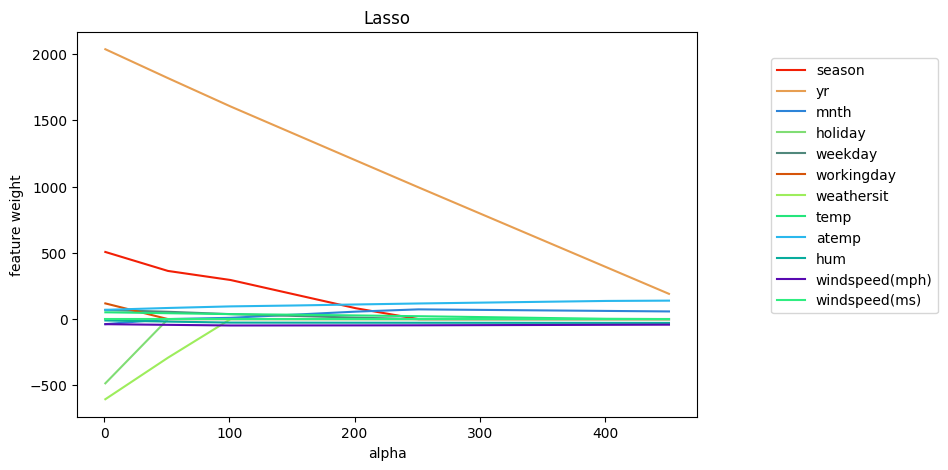

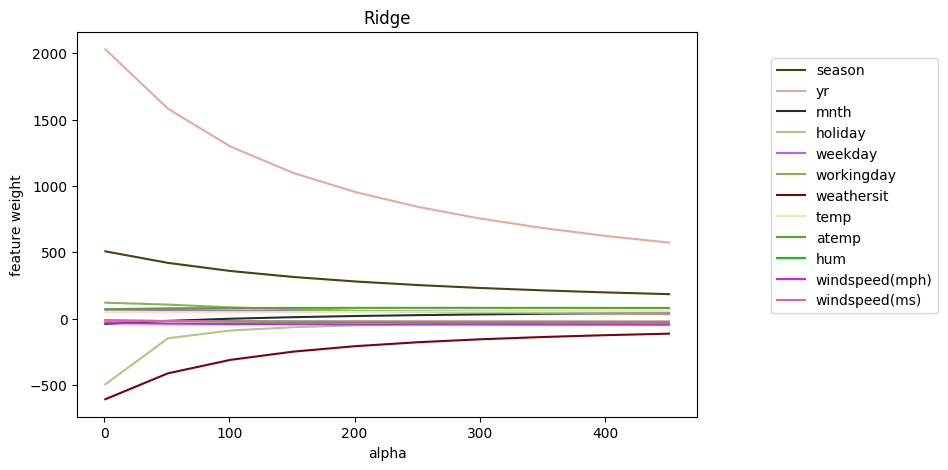

In [42]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?

**Відповідь**:
В графіках видно, що Lasso агресивніше уменьшує ваги при однаковому значенні alpha. Lasso також схильний обнуляти ваги для певних признаків при збільшенні alpha.

2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.

**Відповідь:**
Якщо alpha в Lasso стає дуже великим, то багато ваг буде рівних нулю. Це відбувається через те, що Lasso використовує L1-регуляризацію, яка включає штраф за суму абсолютних значень ваг. Це призводить до того, що частина ваг стає рівною нулю, що робить деякі признаки неактивними.

3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.

**Відповідь:**
Так, Lasso схильний обнуляти один з признаків windspeed при значеннях alpha > 0. На графіках ви бачите, як ваги при windspeed спадають до нуля при збільшенні alpha. З іншого боку, Ridge не обнуляє ваги повністю, але зменшує їх значення. Зазначте, що точні значення, при яких ваги вважаються "виключеними", можуть залежати від конкретного порогу, такого як $10^{-3}$.

4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

**Відповідь:**
Lasso підходить для відбору неінформативних признаків, оскільки він встановлює ваги відповідних признаків рівними нулю. Якщо у вас є група признаків, серед яких є колінеарність або кореляція, Lasso видаляє один з них, що може полегшити роботу з моделлю та зменшити перенавчання.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [51]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()


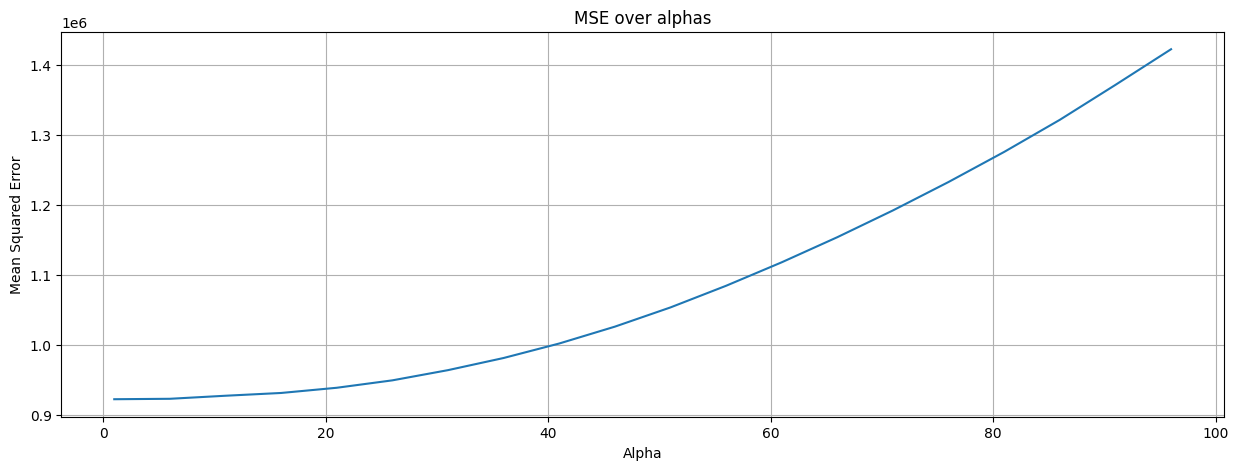

Selected alpha: 1
           Feature  Coefficient
0           season   506.551279
1               yr  2036.231668
2             mnth   -38.078270
3          holiday  -484.651946
4          weekday    68.938375
5       workingday   118.447598
6       weathersit  -604.566712
7             temp    51.363261
8            atemp    69.912737
9              hum   -10.352705
10  windspeed(mph)   -38.341068
11   windspeed(ms)    -0.000000


In [55]:
alphas = np.arange(1, 100, 5)

# Навчання моделі LassoCV
regressor = LassoCV(alphas=alphas, cv=3)
regressor.fit(X, y)

# Побудова графіка
create_plot(
    list(zip(regressor.alphas_, np.mean(regressor.mse_path_, axis=1))),
    'MSE over alphas',
    'Alpha',
    'Mean Squared Error'
)

# Виведення вибраного alpha та ваги коефіцієнтів
print("Selected alpha:", regressor.alpha_)
coefficients = pd.DataFrame(list(zip(X.columns, regressor.coef_)), columns=['Feature', 'Coefficient'])
print(coefficients)

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Alpha values corresponding to minimum MSE on each split:
[ 1 51  1]


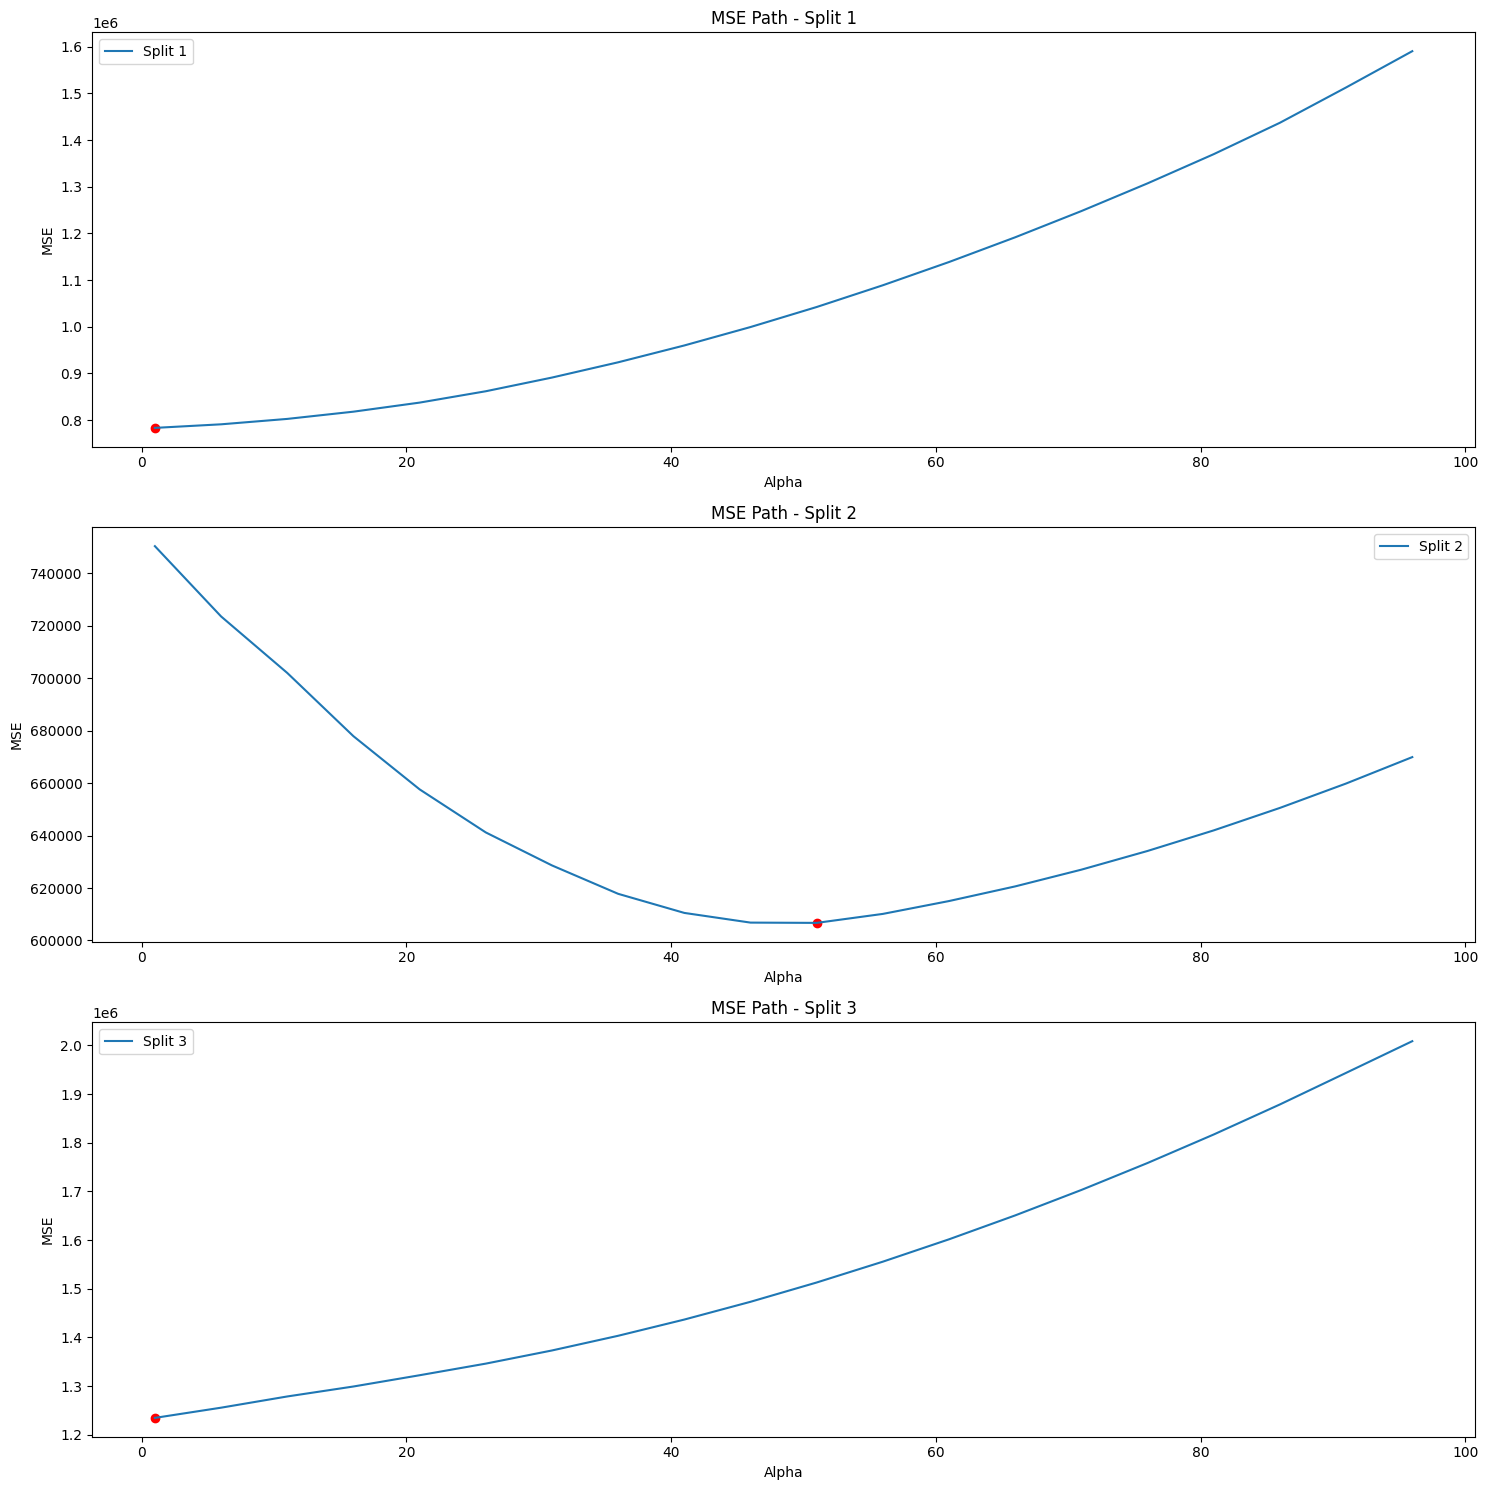

Top 4 features with the largest positive coefficients:
['yr', 'weathersit', 'season', 'holiday']
Top 3 features with the largest negative coefficients:
['windspeed(ms)', 'hum', 'mnth']


In [60]:
# Знайдемо індекси мінімальних значень MSE для кожного розбиття
min_mse_indexes = np.argmin(regressor.mse_path_, axis=0)

# Виведемо значення alpha, що відповідають мінімумам MSE
min_alpha_values = regressor.alphas_[min_mse_indexes]
print("Alpha values corresponding to minimum MSE on each split:")
print(min_alpha_values)

# Візуалізація стовпців mse_path_
plt.figure(figsize=(15, 15))
for i in range(regressor.mse_path_.shape[1]):
    plt.subplot(3, 1, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], label=f'Split {i + 1}')
    plt.scatter(min_alpha_values[i], np.min(regressor.mse_path_[:, i]), color='red')
    plt.title(f'MSE Path - Split {i + 1}')
    plt.xlabel("Alpha")
    plt.ylabel("MSE")
    plt.legend()

plt.tight_layout()
plt.show()
# Відсортуємо признаки за зменшенням їхніх коефіцієнтів
sorted_feature_weights = sorted(zip(df.columns[:-1], regressor.coef_), key=lambda x: -abs(x[1]))

# Виведемо 4 признаки з найбільшими додатними коефіцієнтами
top_positive_features = [feature for feature, weight in sorted_feature_weights[:4]]
print("Top 4 features with the largest positive coefficients:")
print(top_positive_features)

# Відсортуємо признаки за зростанням їхніх коефіцієнтів
sorted_feature_weights = sorted(zip(df.columns[:-1], regressor.coef_), key=lambda x: abs(x[1]))

# Виведемо 3 признаки з найбільшими від'ємними за модулем коефіцієнтами
top_negative_features = [feature for feature, weight in sorted_feature_weights[:3]]
print("Top 3 features with the largest negative coefficients:")
print(top_negative_features)



На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

**Відповідь:**
Так залежності очевидні, чим краща погода або тепліший сезон тим більше орендується велосипедів.

__Ответ:__

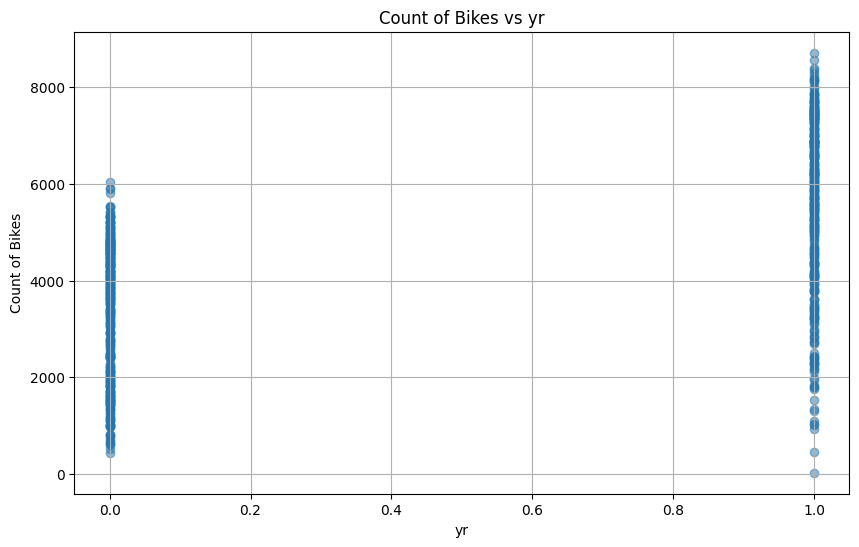

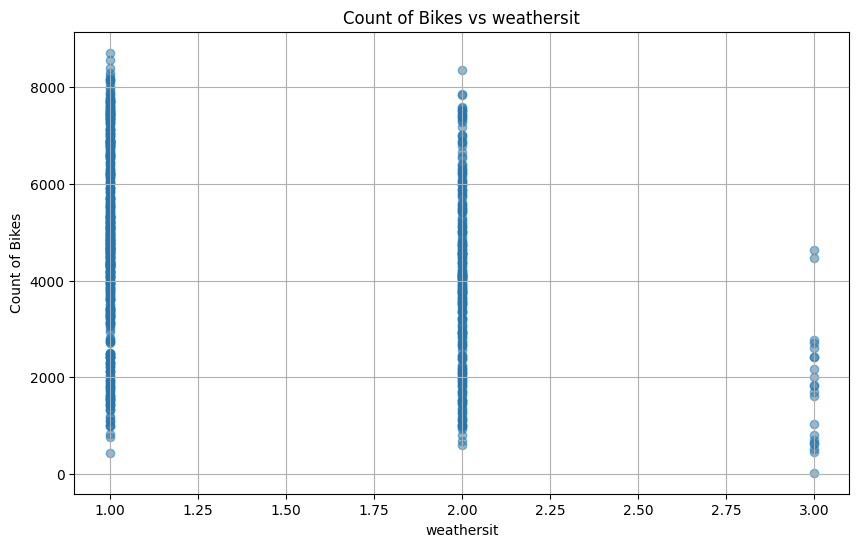

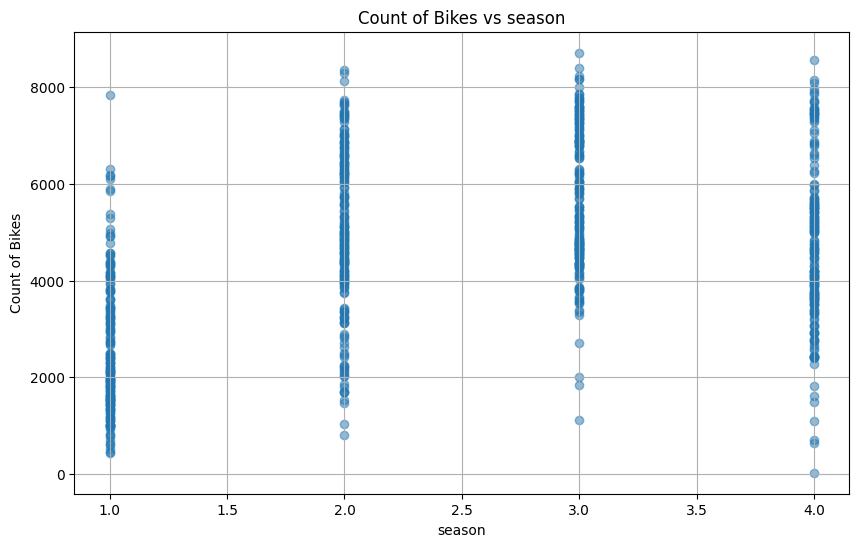

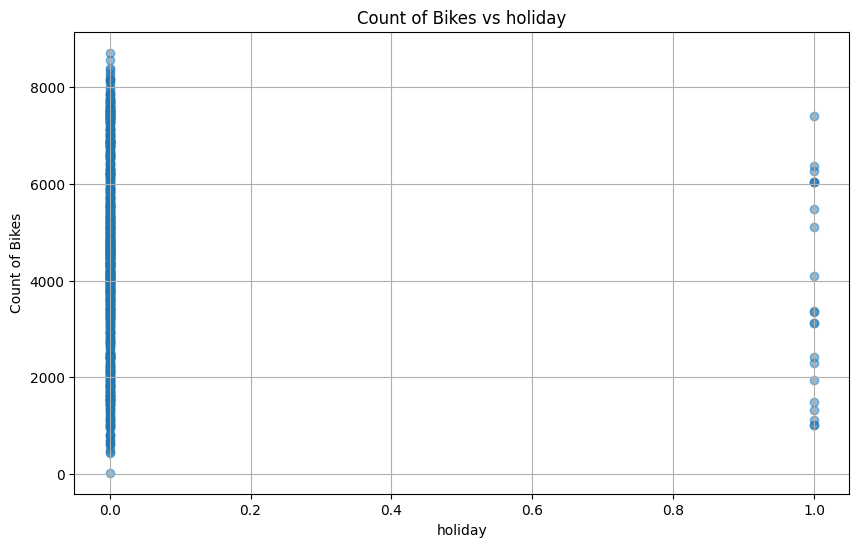

In [58]:
import matplotlib.pyplot as plt

def plot_feature(feature_name, data):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature_name], data['cnt'], alpha=0.5)
    plt.title(f'Count of Bikes vs {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count of Bikes')
    plt.grid(True)
    plt.show()

# Ваші обрані признаки
selected_features = ['yr', 'weathersit', 'season', 'holiday']

# Аналіз графіків для обраних признаків
for feature in selected_features:
    plot_feature(feature, df)


#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

**Відповідь:**
Так видно по швидкості вітру та вологості, але не по місяцях.

__Ответ:__

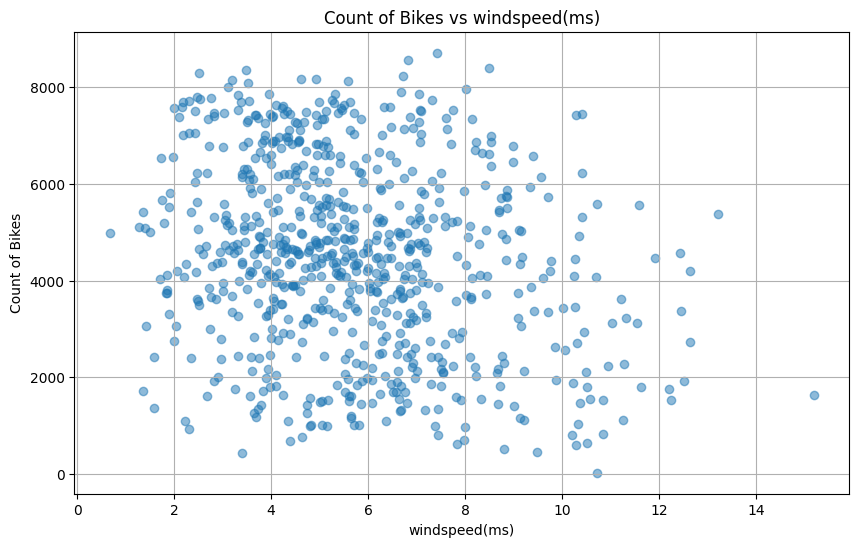

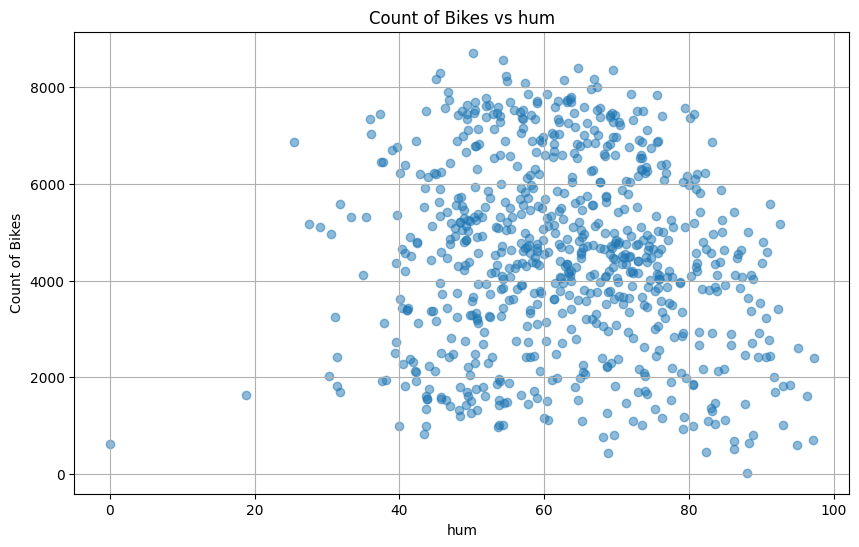

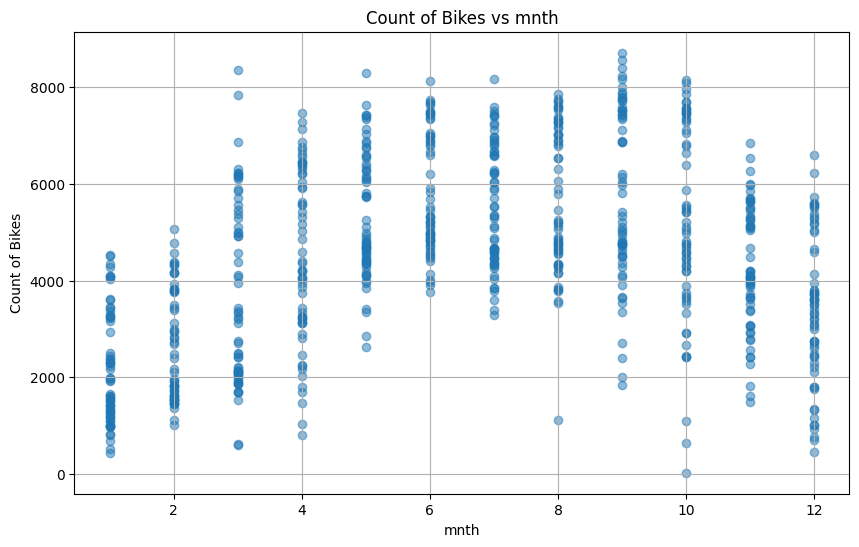

In [61]:
import matplotlib.pyplot as plt

def plot_feature(feature_name, data):
    plt.figure(figsize=(10, 6))
    plt.scatter(data[feature_name], data['cnt'], alpha=0.5)
    plt.title(f'Count of Bikes vs {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Count of Bikes')
    plt.grid(True)
    plt.show()

# Ваші обрані признаки
selected_features = ['windspeed(ms)', 'hum', 'mnth']

# Аналіз графіків для обраних признаків
for feature in selected_features:
    plot_feature(feature, df)


#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

**Відповідь**:
Можливо через велике розсіювання значень на графіках, хоча незначна залежність всеж прослідковується

__Ответ:__

Features with coefficients close to zero:
['windspeed(ms)']


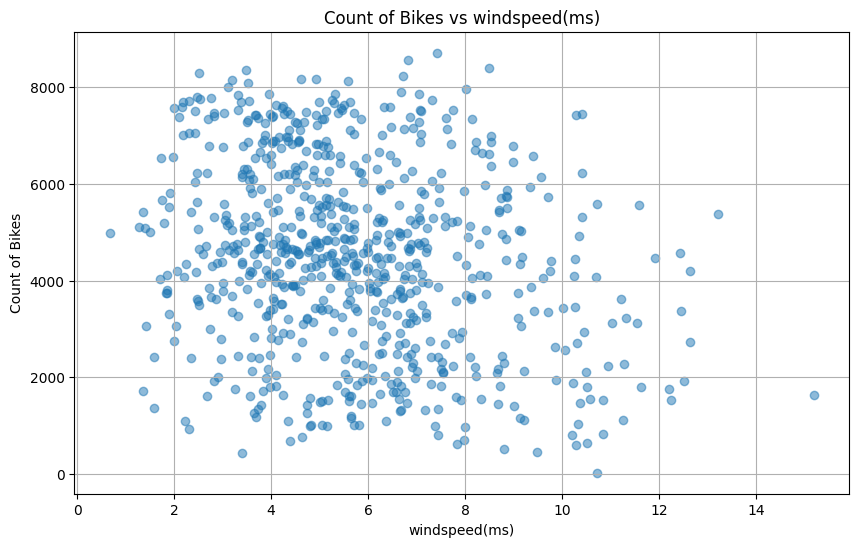

In [63]:
# Відсортуємо признаки за зменшенням їхніх коефіцієнтів
close_to_zero_features = [feature for feature, weight in sorted_feature_weights if abs(weight) < 1e-3]
print("Features with coefficients close to zero:")
print(close_to_zero_features)
# Аналіз графіків для признаків з низькими коефіцієнтами
for feature in close_to_zero_features:
    plot_feature(feature, df)



### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.